In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import EarlyStopping

# Load the dataset
data = pd.read_csv("creditcard.csv") 

# Separate features and labels
X = data.drop(['Class'], axis=1)
y = data['Class']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into training and testing sets (using only non-fraudulent data for training)
X_train, X_test, y_train, y_test = train_test_split(X_scaled[y == 0], y[y == 0], test_size=0.2, random_state=42)

# Define the autoencoder architecture
input_dim = X_train.shape[1]
encoding_dim = 14  # Adjust this as needed

input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation='relu')(input_layer)
decoder = Dense(input_dim, activation='linear')(encoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.compile(optimizer='adam', loss='mse')

# Train the autoencoder
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
autoencoder.fit(X_train, X_train, epochs=50, batch_size=32, validation_data=(X_test, X_test), callbacks=[early_stopping])

# Calculate reconstruction errors for the entire dataset
reconstructions = autoencoder.predict(X_scaled)
mse = np.mean(np.power(X_scaled - reconstructions, 2), axis=1)

# Set a threshold for anomaly detection (you'll need to tune this)
threshold = np.percentile(mse, 95)  # Adjust this percentile as needed

# Identify anomalies
anomalies = (mse > threshold)

# Evaluate the model (using the original labels)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("Accuracy:", accuracy_score(y, anomalies))
print("Precision:", precision_score(y, anomalies))
print("Recall:", recall_score(y, anomalies))
print("F1-Score:", f1_score(y, anomalies))

Epoch 1/50
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 3s 322us/step - loss: 0.6082 - val_loss: 0.4525
Epoch 2/50
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 2s 314us/step - loss: 0.4466 - val_loss: 0.4545
Epoch 3/50
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 2s 309us/step - loss: 0.4483 - val_loss: 0.4534
Epoch 4/50
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 2s 314us/step - loss: 0.4333 - val_loss: 0.4523
Epoch 5/50
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 2s 312us/step - loss: 0.4368 - val_loss: 0.4520
Epoch 6/50
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 2s 313us/step - loss: 0.4520 - val_loss: 0.4529
Epoch 7/50
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 2s 313us/step - loss: 0.4436 - val_loss: 0.4545
Epoch 8/50
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 2s 317us/step - loss: 0.4398 - val_loss: 0.4543
Epoch 9/50
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 2s 313us/step - loss: 0.4385 - val_loss: 0.4540
Epoch 10/50
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 2s 315us/step - loss: 0.4414 - val_loss: 0.4544
8901/8901 ━━━━━━━━━━━━━━━━━━━━ 2s 219us/step
Accuracy: 0.9513179100232789
Precision: 0.030475387964

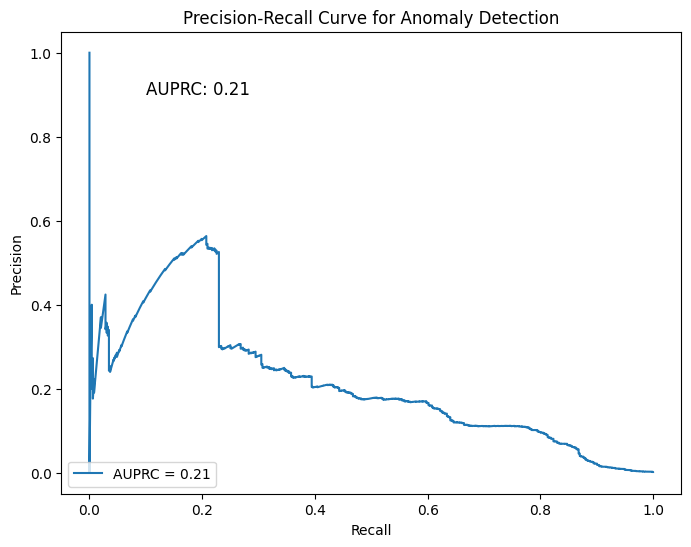

In [3]:
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt


# Calculate precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y, mse)

# Calculate AUPRC
auprc = auc(recall, precision)

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'AUPRC = {auprc:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Anomaly Detection')
plt.legend(loc='lower left')
plt.text(0.1, 0.9, f'AUPRC: {auprc:.2f}', fontsize=12)
plt.show()